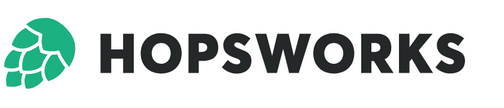

# Data Validation using Hopsworks integration with Great Expectations 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/integrations/great_expectations/fraud_batch_data_validation.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.

The purpose of this notebook is to showcase how **Hopsworks Feature Store** integrates seamlessly with **Great Expectations (GE) library** to perform data validation. Simply define an expectation suite in GE and attach it to a Feature Group. Hopsworks will automatically run validation on insert and centralize your expectation suite as well as validation reports. In addition, you can check the validation history directly in the Feature Group UI page.

Check the step 1 in the fraud batch tutorial to learn more about Feature Group : 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_batch/1_feature_groups.ipynb)


## 🗒️ This notebook is divided in 5 sections:
1. Loading the data and minimal feature engineering,
2. Connect to the Hopsworks feature store,
3. Define Data Validation Pipeline using Great Expectation,
4. Setup Validation on Insert and upload data,
5. Explore Validation Report in Hopsworks UI.


First of all we will load the data and do some feature engineering on it.

In [ ]:
!pip install -U hopsworks --quiet

## <span style="color:#ff5f27;"> 💽 Loading the Data & Minimal Feature Engineering</span>

The data we will use comes from two different CSV files:

- `transactions.csv`: transaction information such as timestamp, location, and the amount. Importantly, the binary `fraud_label` variable tells us whether a transaction was fraudulent or not.
- `profiles.csv`: credit card user information such as birthdate and city of residence.

We can conceptualize these CSV files as originating from separate data sources.
**Both files have a credit card number column `cc_num` in common, which we can use for joins.**

Let's go ahead and load the data.

In [ ]:
import pandas as pd
trans_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/transactions.csv", parse_dates=["datetime"])
trans_df.head(3)
profiles_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/profiles.csv", parse_dates=["birthdate"])
profiles_df.head(3)



This could for instance be the age of a customer at the time of a transaction, which combines the `birthdate` feature from `profiles.csv` with the `datetime` feature from `transactions.csv`.


In [ ]:
import numpy as np

# Compute age at transaction.
age_df = trans_df.merge(profiles_df, on="cc_num", how="left")
trans_df["age_at_transaction"] = (age_df["datetime"] - age_df["birthdate"]) / np.timedelta64(1, "Y")

# Convert date time object to unix epoch in milliseconds
trans_df.datetime = trans_df.datetime.values.astype(np.int64) // 10 ** 6

## <span style="color:#ff5f27;"> 🪄 Creating Feature Groups </span>

A [feature group](https://docs.hopsworks.ai/feature-store-api/latest/generated/feature_group/) can be seen as a collection of conceptually related features. In our case, we will create a feature group for the transaction data. It will have `cc_num` as primary key.

Before we can create a feature group we need to connect to our feature store.

In [ ]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

To create a feature group we need to give it a name and specify a primary key. It is also good to provide a description of the contents of the feature group and a version number, if it is not defined it will automatically be incremented to `1`.

In [ ]:
trans_fg = fs.get_or_create_feature_group(
    name="ge_transactions_fg",
    version=1,
    description="Transaction data",
    primary_key=['cc_num'],
    event_time=['datetime']
)

A full list of arguments can be found in the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/feature_store_api/#create_feature_group).

At this point, we have only specified some metadata for the feature group. It does not store any data or even have a schema defined for the data. To make the feature group persistent we populate it with its associated data using the `insert` function. We are inserting a single row here.

In [ ]:
trans_fg.insert(trans_df.head(1))

At the creation of the feature group, you will prompted with an URL that will directly link to it; there you will be able to explore some of the aspects of your newly created feature group.

[//]: <> (insert GIF here)

### Define Data Validation Pipeline using Great Expectations

An Expectation Suite in Great Expectations contains multiple expectations which will be evaluated against a DataFrame on validation. This step will generate a report gathering information on whether the DataFrame fulfills those expectations. Setup the validation pipeline using the usual GE object and syntax. Once your expectation suite is ready, register it with the Hopsworks backend.

In [ ]:
import great_expectations as ge
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

#### Exploring and Defining an Expectation Suite

When prototyping an expectation suite you can use the Great Expectations DataFrame wrapper to evaluate expectations directly and enable auto-complete.

In [ ]:
ge_trans_df = ge.from_pandas(trans_df)

# Check if trans_df is sorted according to datetime
validation_result = ge_trans_df.expect_column_values_to_be_increasing(
    column="datetime",
    strictly=True
)

print(validation_result)

Note that this does not append the expectation to the suite, however the result contains all the necessary information to recreate the expectation. 

In [ ]:
expectation_suite_trans = ge_trans_df.get_expectation_suite()
expectation_suite_trans.expectation_suite_name = "transaction_suite"
print(expectation_suite_trans)

In [ ]:
expectation_suite_trans.add_expectation(validation_result["expectation_config"])
print(expectation_suite_trans)

You can populate the suite with various expectation configurations. Many standard expectations are implemented in Great Expectations, from computing the mean of a column to counting the number of null values for example.

In [ ]:
# Check for errors which could lead to technical issues

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_unique",
        kwargs={"column":"tid", "result_format":"COMPLETE"}
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_in_set",
        kwargs={
            "column":"fraud_label",
            "value_set": [0,1]
        }
    )
)

# Assess data correctness

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"amount",
            "min_value": 0
        }
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"age_at_transaction",
            "min_value": 18,
            "max_value": 130
        }
    )
)

# Or simply to monitor data statistics and quality, e.g number of null values

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
      expectation_type="expect_column_mean_to_be_between",
      kwargs={"column":"age_at_transaction", "min_value": 0, "max_value": 100}
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_value_to_be_null",
        kwargs={"column":"category"}
    )
)


In [ ]:
ge_trans_df = ge.from_pandas(trans_df, expectation_suite=expectation_suite_trans)

validation_report_trans = ge_trans_df.validate()

#### Generate an Expectation Suite from your data using Great Expectations Profiler

For complex DataFrames, Great Expectations offers a profiler which generates a basic expectation suite tailored to your data. You can then use this suite as you would any other expectation suite with Hopsworks.

In [ ]:
# ignore deprecation warnings
expectation_suite_profiled, validation_report = ge_trans_df.profile(profiler=ge.profile.BasicSuiteBuilderProfiler)

print(f"The suite contains {len(expectation_suite_profiled['expectations'])} expectations for {len(trans_df.columns.values)} columns. See sample below\n" + ge_trans_df.get_expectation_suite().__repr__()[:455])

Note that you cannot register the report generated by the profiler as the suite was not registered with Hopsworks before the validation was run.

### Setup Validation On Insert and Upload Data

Register the expectation suite corresponding to a Feature Group with the backend

In [ ]:
# The "ALWAYS" ingestion policy inserts data even when validation fails, 
# ideal to avoid data loss and rapid prototyping
trans_fg.save_expectation_suite(expectation_suite_trans, validation_ingestion_policy="ALWAYS")

Once the suite is registered in the backend, data validation will run on every insert without additional boilerplate. The suite is retrieved from the backend, used to validate the DataFrame and the resulting validation report uploaded. Depending on the ingestion policy and validation success, data are subsequently inserted in the Feature Group.

In [ ]:
trans_job, trans_report = trans_fg.insert(trans_df)

The "STRICTLY" ingestion policy aborts insertion job if the validation fails.

In [ ]:
# The "STRICT" ingestion policy only inserts data when data validation succeeds,
# perfect for production environment 
trans_fg.save_expectation_suite(expectation_suite_trans, validation_ingestion_policy="STRICT")

trans_job, trans_report = trans_fg.insert(trans_df)
print(f"insertion job : {trans_job}")

### Retrieve or Explore Validation Reports in Hopsworks UI

Follow the links to explore a summary of the validation reports generated by Great Expectations directly in the Feature Group page!

Despite some expectations in the validation step raising exception or failing, you can see that the trans DataFrame has been inserted in the Feature Group. In the validation results tab, you can see one expectation fail was caused by an unexpected young customer making a transaction. You can download the full report to investigate errors like exception or more complex results.


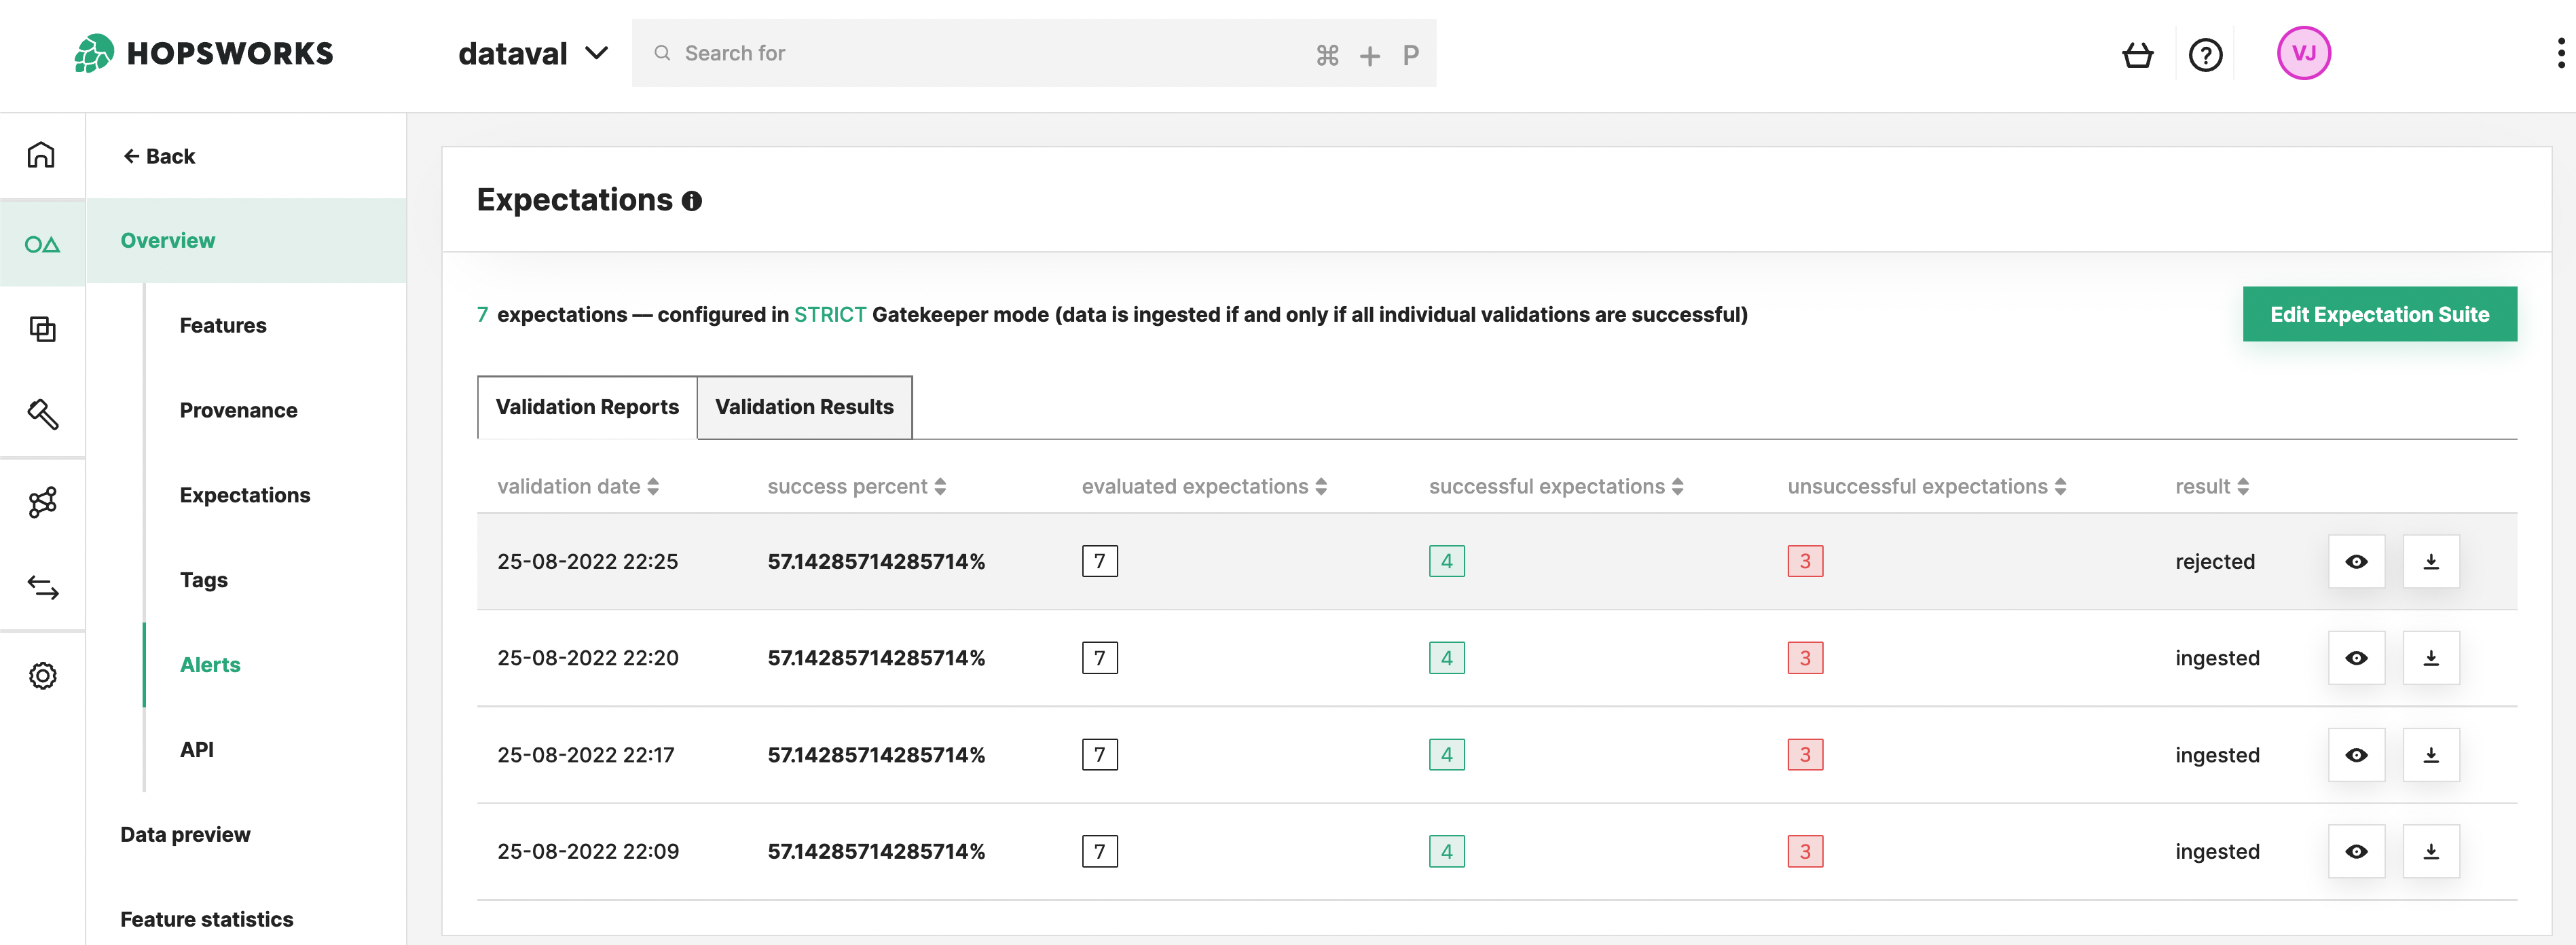

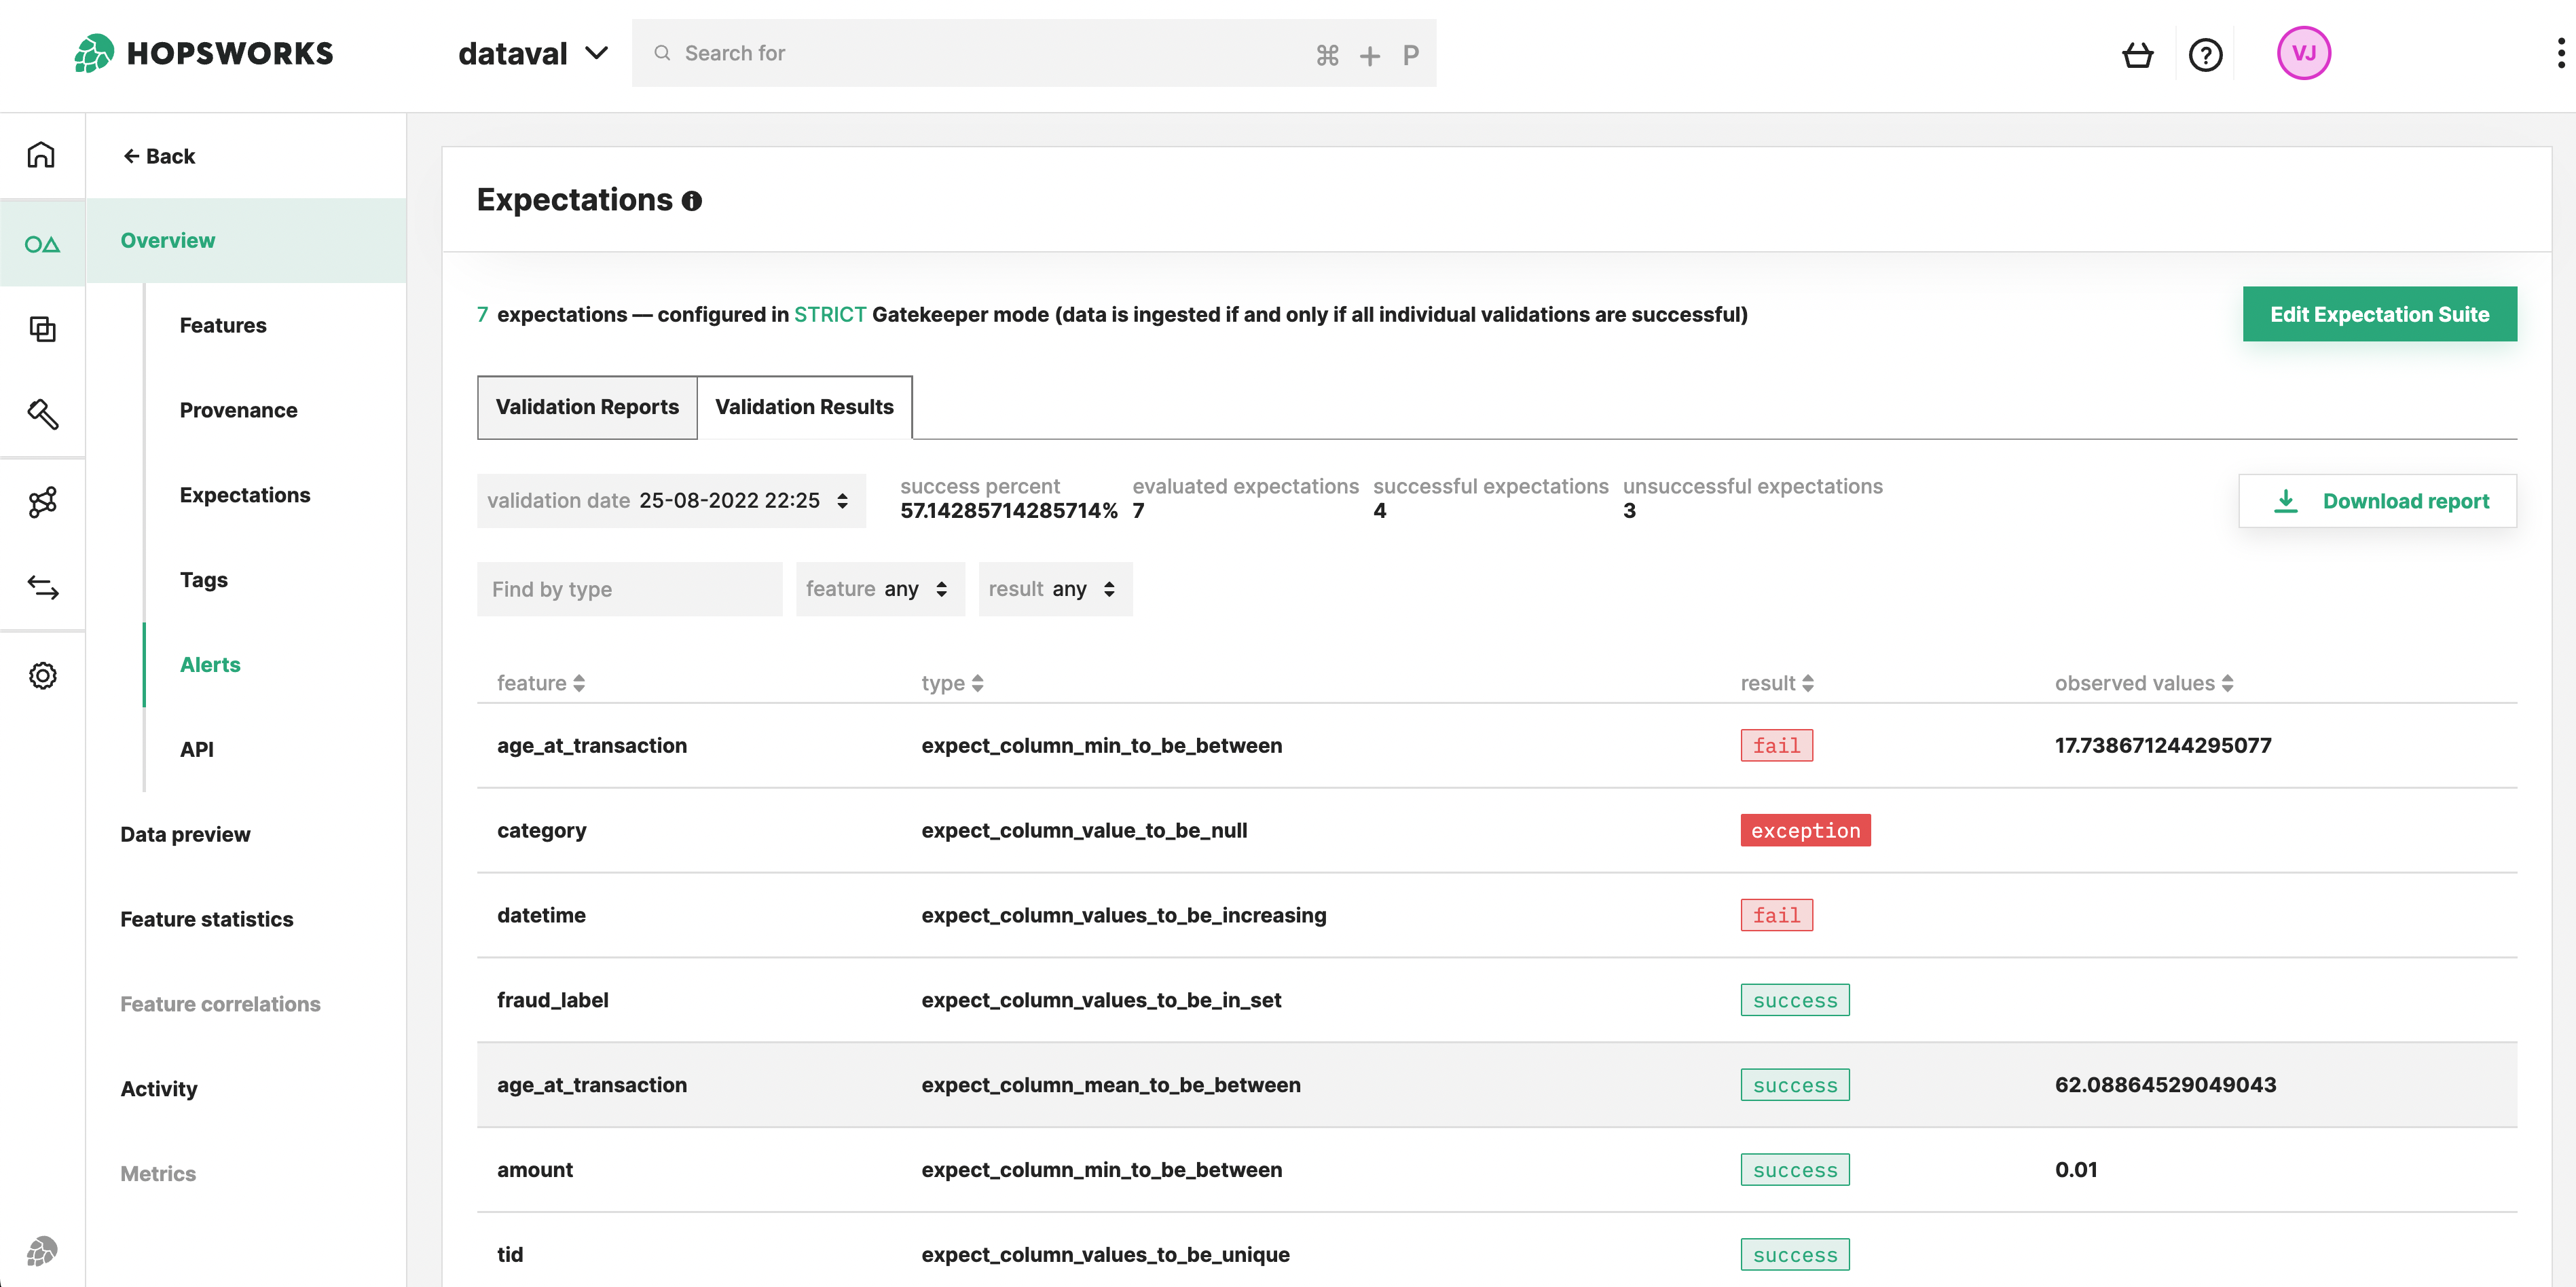

On the other hand, setting the ingestion policy to "STRICT" for the window_agg_fg lead to the abortion of the insertion job. You can however bypass the validation if needed (e.g. time critical backfilling)

In [ ]:
trans_fg.insert(trans_df.head(5), validation_options={"run_validation": False})

You can also retrieve validation report summaries via the python client. Feature Groups provide a convenience method to get the latest summary uploaded for quick prototyping.

In [ ]:
trans_all_validation_report_summaries = trans_fg.get_all_validation_reports()

last_trans_summary = trans_fg.get_latest_validation_report()

### Next Step: Use your own data and the Great Expectations profiler to create a data validated Feature Group in Hopsworks!

Load your own data, use the GE profiler to generate a tailored suite and insert it into hopsworks in a 4 lines of code.

In [ ]:
# Load sample data. Replace it with your own!
my_data_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/credit_cards.csv")

# Use Great Expectation profiler (ignore deprecation warning)
expectation_suite_profiled, validation_report = ge.from_pandas(my_data_df).profile(profiler=ge.profile.BasicSuiteBuilderProfiler)

# Create a Feature Group on hopsworks with an expectation suite attached. Don't forget to change the primary key!
my_validated_data_fg = fs.get_or_create_feature_group(name="my_validated_data_fg", version=1, description="My data", primary_key=['cc_num'], expectation_suite=expectation_suite_profiled)

# Insert and validate your data
insert_job, validation_report = my_validated_data_fg.insert(my_data_df)